- **Invoice Number:** Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.  
- **Stock Code:** Nominal. A 5-digit integral number uniquely assigned to each distinct product.  
- **Description:** Nominal. Description of the product.  
- **Quantity:** Numeric. The quantities of each product (item) per transaction.  
- **Invoice Date:** Numeric. The date and time when a transaction was generated.  
- **Unit Price:** Numeric. Product price per unit.  
- **Customer ID:** Nominal. A 5-digit integral number uniquely assigned to each customer.  
- **Country:** Nominal. The name of the country where a customer resides.  

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from warnings import filterwarnings
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes import BetaGeoFitter,GammaGammaFitter

In [72]:
df = pd.read_excel("online_retail.xlsx")

In [74]:
df.head(1)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom

In [75]:
df.tail(1)

Invoice StockCode             Description  Quantity  \
525460  538171     21931  JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price  Customer ID         Country  
525460 2010-12-09 20:01:00   1.95      17530.0  United Kingdom

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


**As we want to calculate the CLV of Customers we have to drop nulls in the customerID Column**

In [77]:
df.dropna(axis=0,subset="Customer ID",inplace=True)

In [78]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date

In [79]:
df.shape

(417534, 8)

In [80]:
df.size

3340272

In [81]:
df.describe()

Quantity          Price    Customer ID
count  417534.000000  417534.000000  417534.000000
mean       12.758815       3.887547   15360.645478
std       101.220424      71.131797    1680.811316
min     -9360.000000       0.000000   12346.000000
25%         2.000000       1.250000   13983.000000
50%         4.000000       1.950000   15311.000000
75%        12.000000       3.750000   16799.000000
max     19152.000000   25111.090000   18287.000000

In [82]:
df.describe(include=["object"])

Invoice StockCode                         Description InvoiceDate  \
count    417534    417534                              417534      417534   
unique    23587      4031                                4459         307   
top      500356    85123A  WHITE HANGING HEART T-LIGHT HOLDER  2010-11-21   
freq        270      3245                                3245        3258   

               Country  
count           417534  
unique              37  
top     United Kingdom  
freq            379423

In [83]:
df = df[df["Quantity"] > 0]

In [84]:
print("Number of Customers:", df["Customer ID"].nunique())

Number of Customers: 4314


In [85]:
filterwarnings("ignore")

In [86]:
df["Sales"] = df["Price"] * df["Quantity"]

In [87]:
df.drop(columns=["Price","Quantity"],inplace=True)

In [88]:
df.drop(columns=["Description","StockCode"],inplace=True)

In [103]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [104]:
# df.drop(columns="Invoice",inplace=True)

In [89]:
df.groupby("Customer ID")["Sales"].sum().sort_values(ascending=False)

Customer ID
18102.0    349164.35
14646.0    248396.50
14156.0    196566.74
14911.0    152147.57
13694.0    131443.19
             ...    
15913.0         6.30
13788.0         3.75
14095.0         2.95
14103.0         0.00
14827.0         0.00
Name: Sales, Length: 4314, dtype: float64

In [90]:
df = df[~(df["Customer ID"].isin([14827,14103]))]

In [91]:
df.groupby("Customer ID")["Sales"].sum().sort_values(ascending=False)

Customer ID
18102.0    349164.35
14646.0    248396.50
14156.0    196566.74
14911.0    152147.57
13694.0    131443.19
             ...    
18115.0         9.70
15040.0         7.49
15913.0         6.30
13788.0         3.75
14095.0         2.95
Name: Sales, Length: 4312, dtype: float64

In [92]:
df["Customer ID"] = df["Customer ID"].astype(np.int16)

In [93]:
df["Sales"].max()

15818.4

In [94]:
df["Sales"] = df["Sales"].astype(np.float16)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242079 entries, 0 to 242078
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      242079 non-null  object 
 1   InvoiceDate  242079 non-null  object 
 2   Customer ID  242079 non-null  int16  
 3   Country      242079 non-null  object 
 4   Sales        242079 non-null  float16
dtypes: float16(1), int16(1), object(3)
memory usage: 6.5+ MB


**I Turned Data from 32MB into 6.5MB which will lead to easier manipulation**

In [96]:
df.dtypes

Invoice         object
InvoiceDate     object
Customer ID      int16
Country         object
Sales          float16
dtype: object

**CustomerID**: A unique identifier for each customer.

**frequency**: The number of repeat purchases a customer has made (i.e., the number of transactions minus one). If the value is zero, it means the customer has made only one transaction.

**recency**: The time between the customer's first purchase and their last purchase (in units like days or months). It indicates how recently the customer made their last transaction.

**T**: The time between the customer's first purchase and the end of the observation period. This represents how long we have been tracking the customer (the "customer lifetime" in the data).

**monetary_value**: The average value of a customer’s purchases during the observation period. This field is included if the monetary_value_col is specified.

In [107]:
# Saving the clean Data
df.to_csv("cleaned.csv",header=True,index=False)

In [2]:
df = pd.read_csv("cleaned.csv")

In [3]:
print(df["InvoiceDate"].min())

2009-12-01


In [4]:
print(df["InvoiceDate"].max())

2010-12-09


In [5]:
df.shape

(242079, 5)

In [6]:
data = summary_data_from_transaction_data(df, 'Customer ID', 'InvoiceDate', monetary_value_col='Sales',observation_period_end='2010-12-1')
data.head()

frequency  recency      T  monetary_value
Customer ID                                           
12346              6.0    196.0  352.0       21.698333
12347              0.0      0.0   31.0        0.000000
12348              0.0      0.0   65.0        0.000000
12349              2.0    182.0  216.0      500.160000
12351              0.0      0.0    2.0        0.000000

Customers with monetary value = 0 aren't considered to be customers

In [7]:
data = data[data["monetary_value"] > 0]

avg_lifespan = 712  
data["active"] = data.apply(lambda x:1 if x["frequency"] == 0 else x["T"],axis=1)  
data["avg_rev"] = data["monetary_value"] / data["active"]  
data["clv"] = data["avg_rev"] * avg_lifespan  

<Axes: xlabel='frequency', ylabel='Density'>

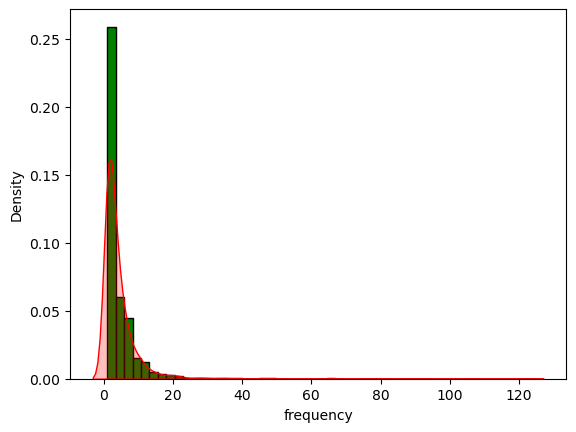

In [8]:
plt.hist(x=data["frequency"],bins = 50,edgecolor='black',density=True,color='green')
sns.kdeplot(data["frequency"],color='red',shade=True)

In [9]:
print(data.describe())

         frequency      recency            T  monetary_value
count  2775.000000  2775.000000  2775.000000     2775.000000
mean      4.384505   202.334054   258.955676      295.556274
std       6.778841   108.087056    98.587617      338.805638
min       1.000000     1.000000     8.000000        7.900000
25%       1.000000   113.000000   196.000000      145.541250
50%       3.000000   211.000000   283.000000      220.950000
75%       5.000000   298.000000   352.000000      333.995000
max     123.000000   365.000000   365.000000     7443.867500


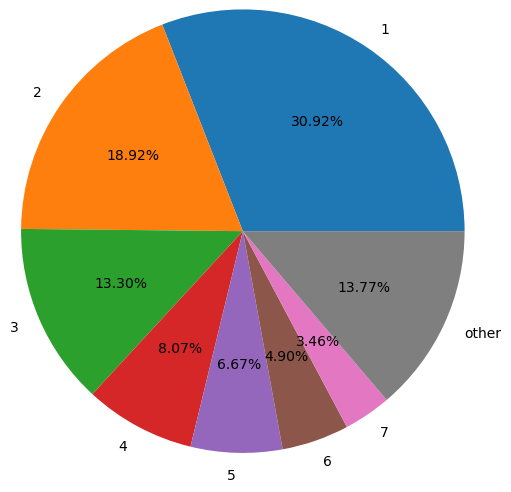

In [10]:
top7 = data["frequency"].value_counts()[:7]
other = data["frequency"].value_counts()[8:]
top7.index = top7.index.astype(int)
top7['other'] = other.sum()
plt.pie(x=top7.values,labels=top7.index,autopct='%.2f%%',radius= 1.5)
plt.show()

In [11]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data["frequency"],data["recency"],data["T"])

<lifetimes.BetaGeoFitter: fitted with 2775 subjects, a: 0.01, alpha: 112.66, b: 0.30, r: 1.97>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

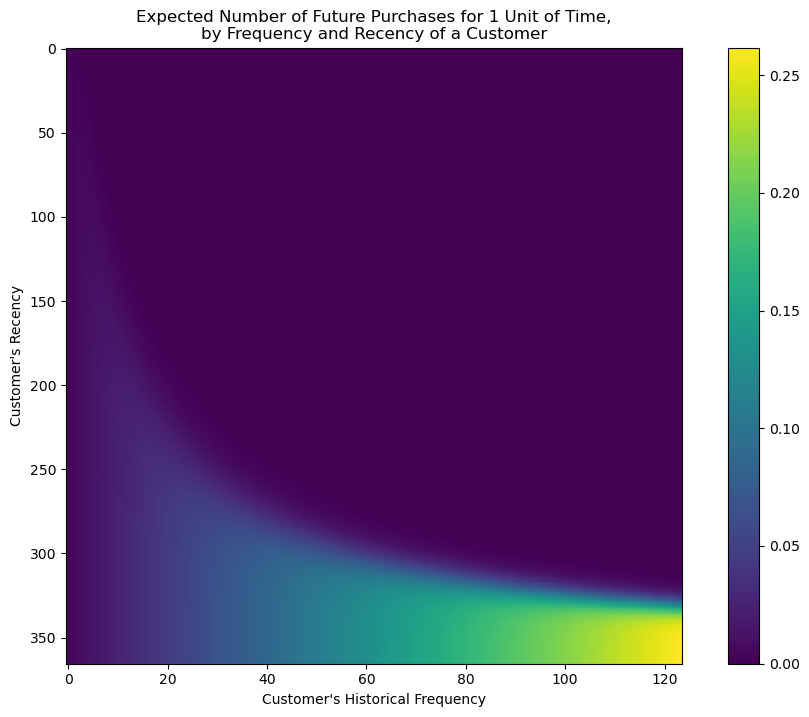

In [12]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

**High Recency & Low Frequency**: Customers who made a purchase recently but haven't made many purchases overall. The probability of them being alive can vary depending on how recent their last purchase was.  
**High Recency & High Frequency**: These customers are highly engaged and are very likely to still be alive. They buy frequently and made a recent purchase.  
**Low Recency & Low Frequency**: Customers who made very few purchases and haven't bought anything in a long time. They are very likely to have churned.  
**Low Recency & High Frequency**: These customers used to buy frequently, but haven’t made any recent purchases, meaning there’s a risk they have churned.  

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

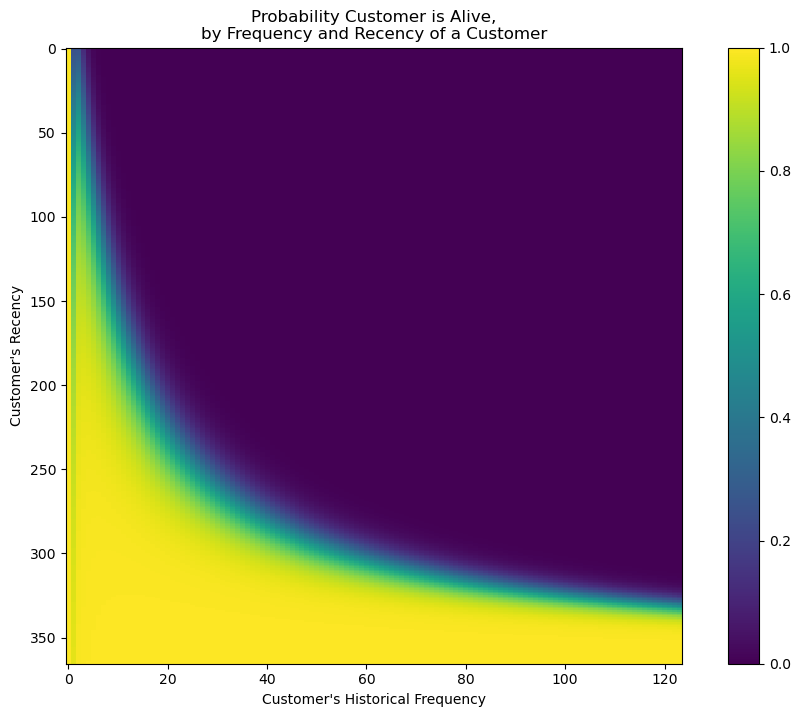

In [13]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

**I will try to predict the clv of customer for the next two years**

**Supposing that the average customer lifetime is 3 years**

In [14]:
avg_lifespan = int((3 * 365 - 365))

In [15]:
data["expected_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(avg_lifespan,frequency=data['frequency'],recency=data["recency"],T=data['T'])
data['avg_transaction_value'] = data["monetary_value"]
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(data["frequency"],data["avg_transaction_value"])
data["expected_avg_value"] = ggf.conditional_expected_average_profit(data['frequency'], data['avg_transaction_value'])
data['CLV'] = data['expected_purchases'] * data['expected_avg_value']

In [16]:
data

frequency  recency      T  monetary_value  expected_purchases  \
Customer ID                                                                  
12346              6.0    196.0  352.0       21.698333           11.682949   
12349              2.0    182.0  216.0      500.160000            8.559101   
12352              1.0     17.0   19.0      182.190000           15.327109   
12356              2.0     44.0   51.0     1227.185000           17.136569   
12358              2.0    356.0  358.0      459.290000            6.024217   
...                ...      ...    ...             ...                 ...   
18276              4.0    337.0  356.0      195.965000            9.163556   
18277              2.0     97.0  121.0      199.910000           12.003482   
18283              4.0    276.0  285.0       76.130000           10.793325   
18286              1.0    247.0  350.0      418.610000            4.235665   
18287              2.0    189.0  198.0      383.315000            9.087212   

             avg_transaction_value  expected_avg_value           CLV  
Customer ID                                                           
12346                    21.698333           63.432243    741.075686  
12349                   500.160000          429.465068   3675.835040  
12352                   182.190000          241.738473   3705.151897  
12356                  1227.185000          903.038747  15474.985852  
12358                   459.290000          402.842935   2426.813217  
...                            ...                 ...           ...  
18276                   195.965000          217.372355   1991.903738  
18277                   199.910000          233.886516   2807.452466  
18283                    76.130000          122.835016   1325.798265  
18286                   418.610000          355.930205   1507.601129  
18287                   383.315000          353.353908   3211.002042  

[2775 rows x 8 columns]

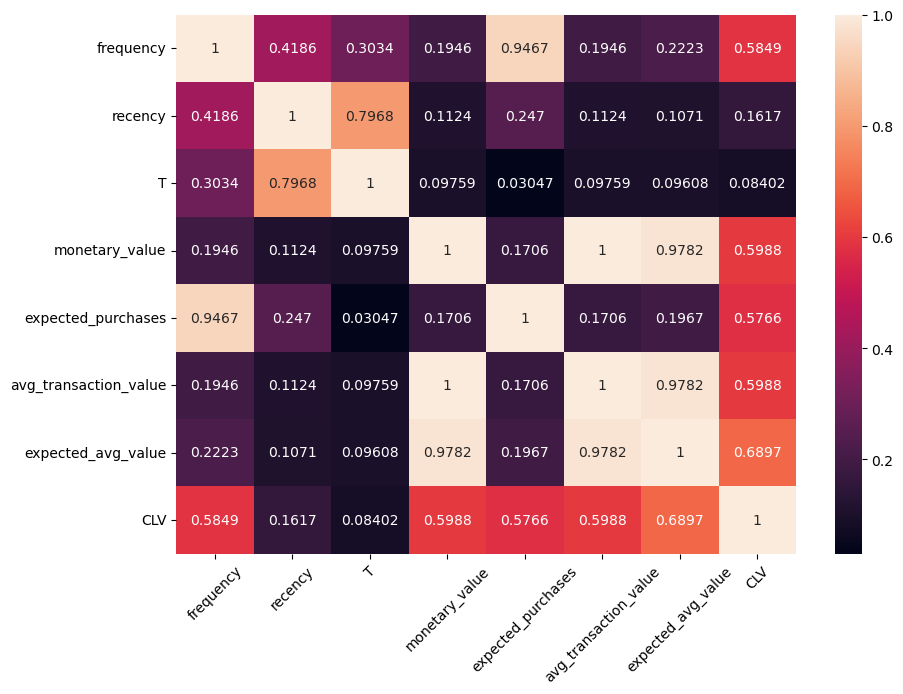

In [17]:
plt.figure(figsize=(10,7))
sns.heatmap(data.reset_index(drop=True).corr(),annot=True,fmt='.4g')
plt.xticks(rotation=45)
plt.savefig("corr.jpg",dpi=300,bbox_inches='tight', pad_inches=0.5)
plt.show()

**frequency -> expected purchase**    
**monetary value -> avg transaction value**  
**recency -> T**  
**avg transaction value -> expected avg value**  
**expected avg value -> monetary value**    

In [18]:
data.reset_index(drop=True,inplace=True)

In [19]:
data.drop(columns=["avg_transaction_value","monetary_value"],inplace=True)

In [20]:
l = data.columns.to_list()
l.remove("CLV")

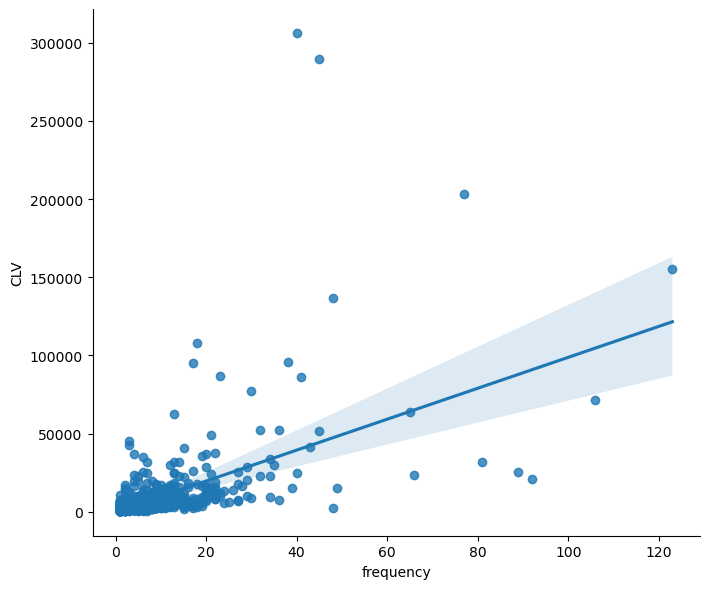

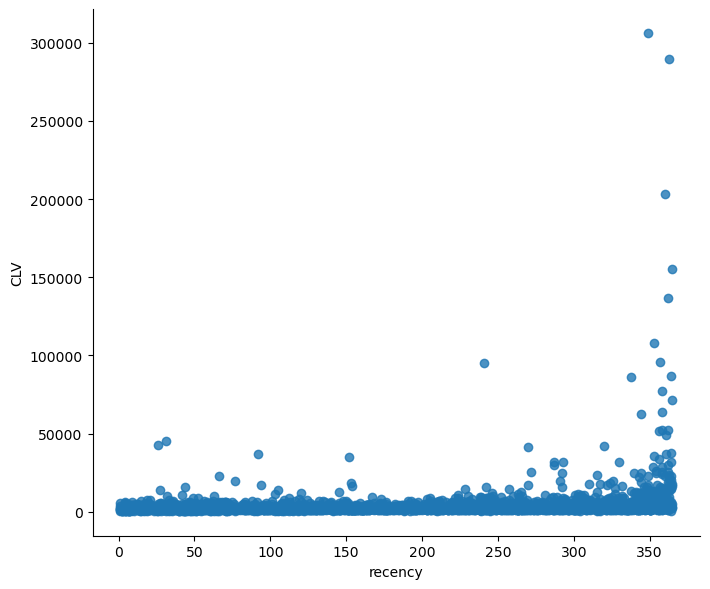

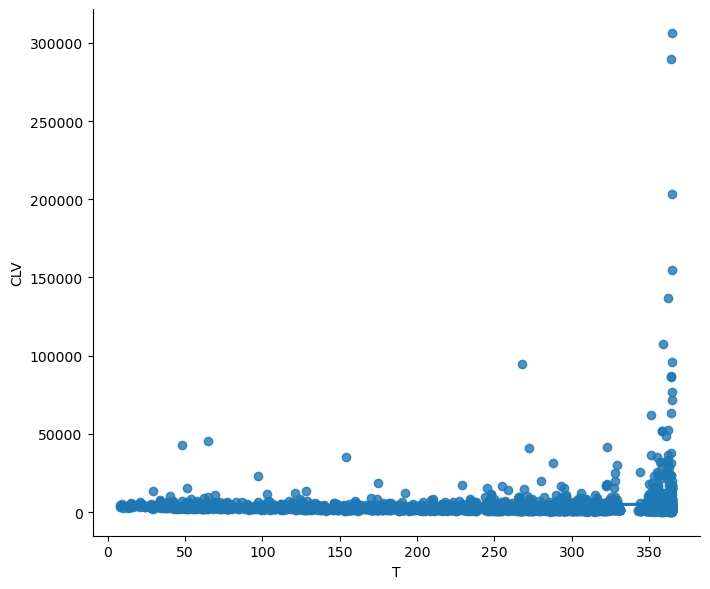

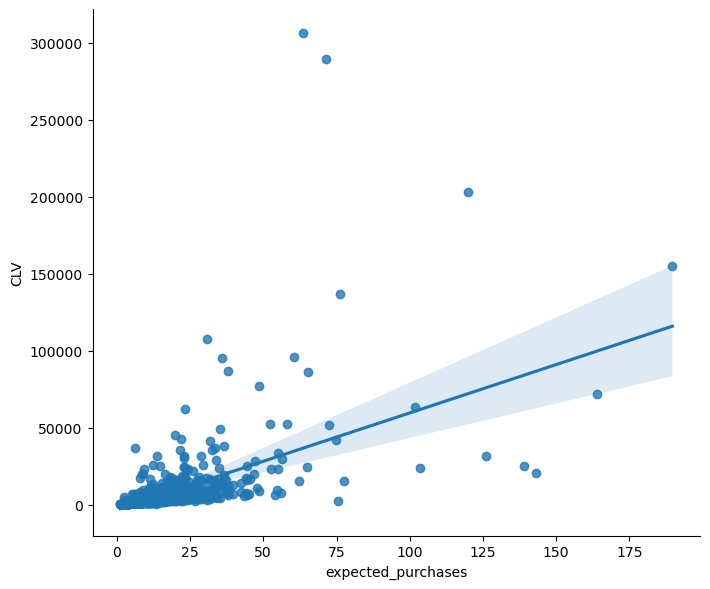

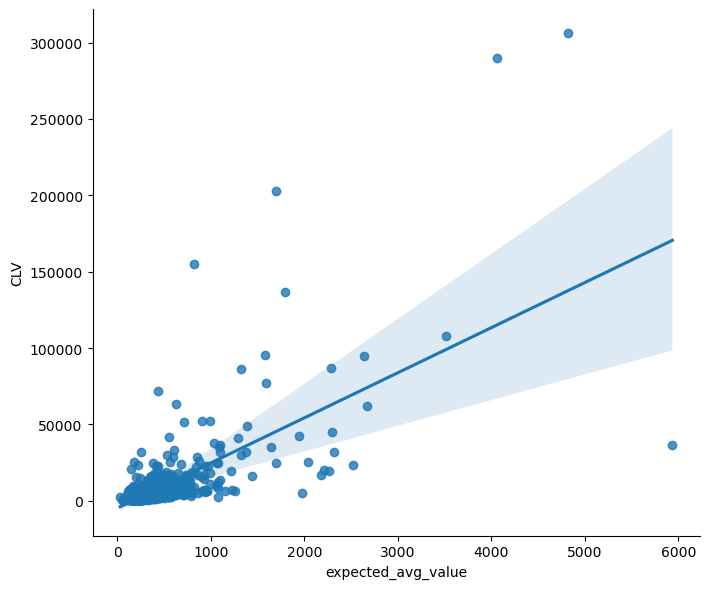

In [21]:
for x in l:
    sns.lmplot(data,x=x,y='CLV',aspect=1.2,height=6)

(-10000.0, 100000.0)

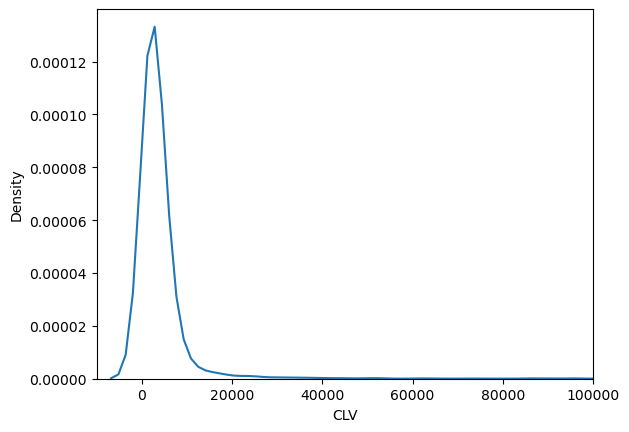

In [22]:
sns.kdeplot(data["CLV"])
plt.xlim((-10000,100000))

**Distribution is left skewed so I will use IQR to remove outliers**

In [23]:
data.shape

(2775, 6)

In [24]:
# Removing outliers
q1,q2,q3 = data["CLV"].quantile(q=[0.25,0.5,0.75])
iqr = q3 - q1
data[((data["CLV"] >= q1-1.5*iqr) & (data["CLV"] <= q3+ 1.5 * iqr))].shape
data = data[((data["CLV"] >= q1-1.5*iqr) & (data["CLV"] <= q3+ 1.5 * iqr))]

<Axes: xlabel='CLV', ylabel='Density'>

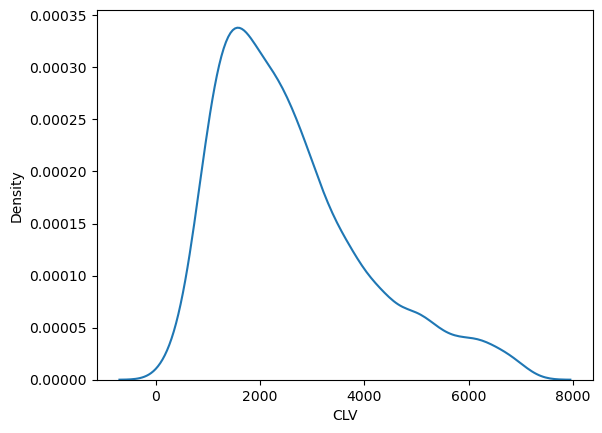

In [25]:
sns.kdeplot(data["CLV"])

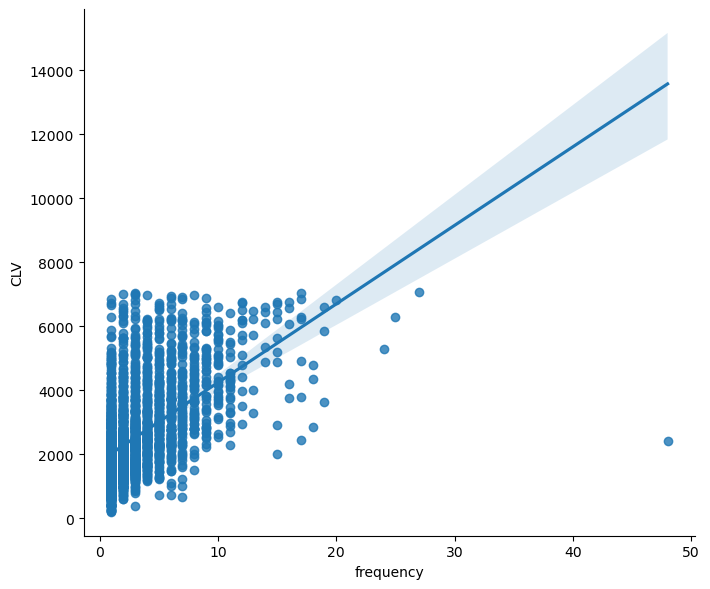

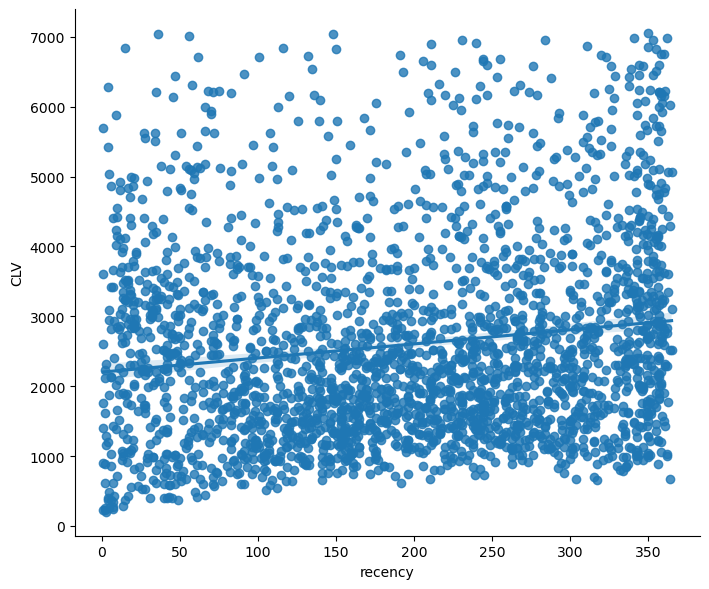

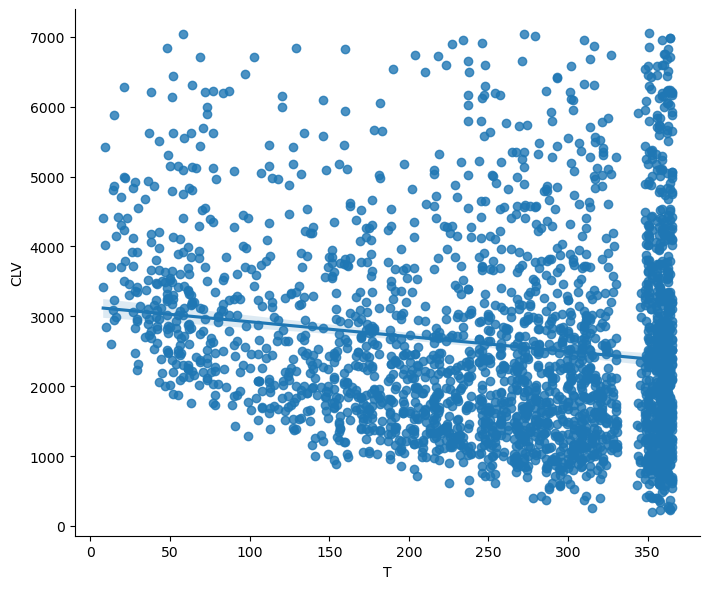

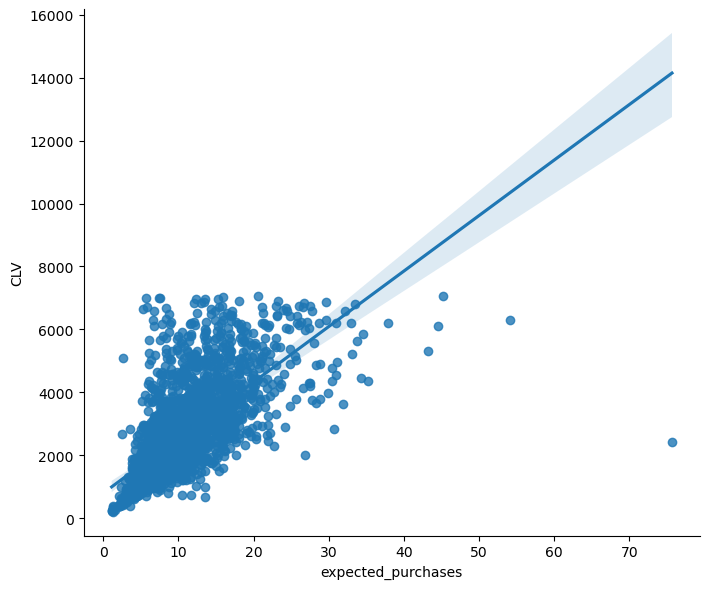

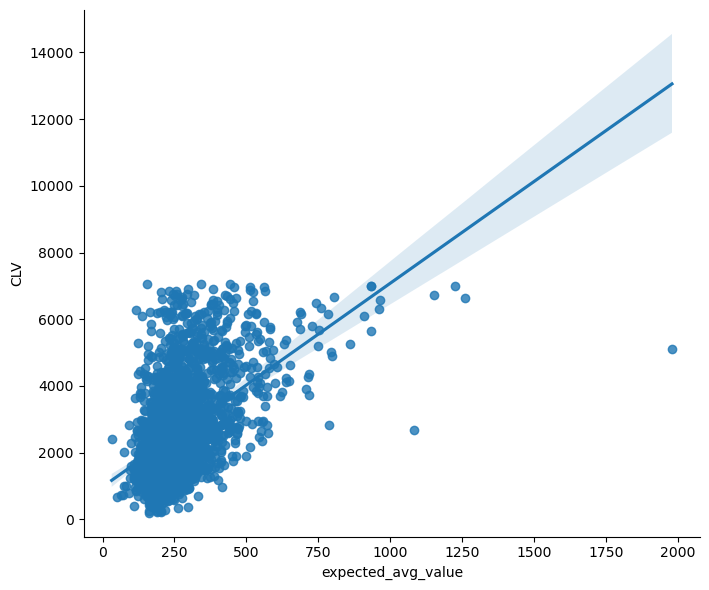

In [26]:
for x in l:
    sns.lmplot(data,x=x,y='CLV',aspect=1.2,height=6)

In [27]:
data.head()

frequency  recency      T  expected_purchases  expected_avg_value  \
0        6.0    196.0  352.0           11.682949           63.432243   
1        2.0    182.0  216.0            8.559101          429.465068   
2        1.0     17.0   19.0           15.327109          241.738473   
4        2.0    356.0  358.0            6.024217          402.842935   
5        5.0    309.0  361.0           10.573797          254.839159   

           CLV  
0   741.075686  
1  3675.835040  
2  3705.151897  
4  2426.813217  
5  2694.617526

In [28]:
data.columns

Index(['frequency', 'recency', 'T', 'expected_purchases', 'expected_avg_value',
       'CLV'],
      dtype='object')

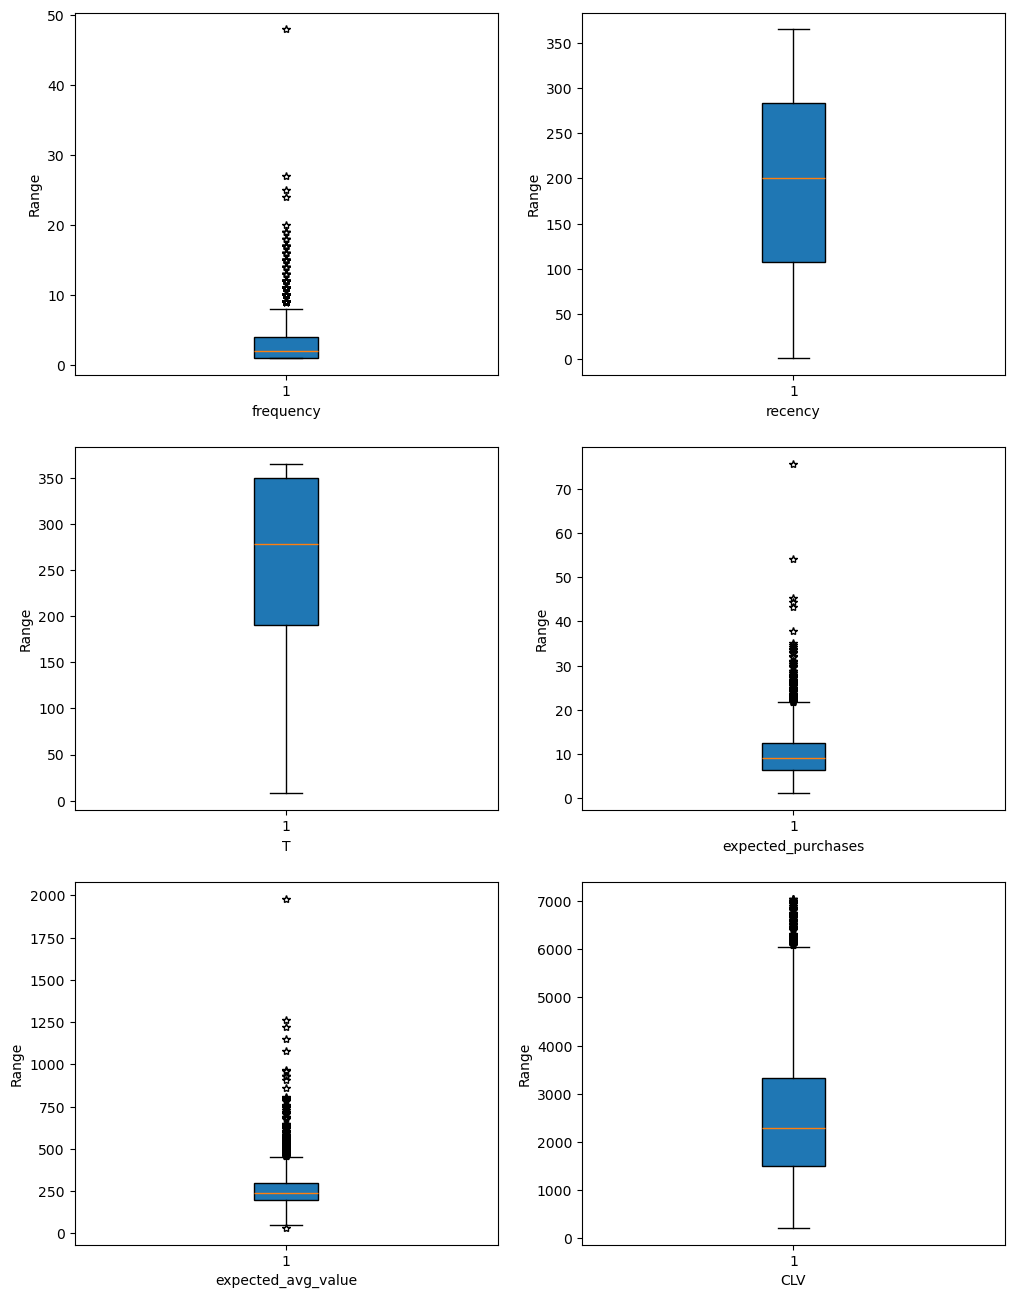

In [29]:
f,ax = plt.subplots(3,2,figsize=(12,16))
ax = ax.flatten()
for i,x in enumerate(data.columns):
    ax[i].boxplot(data[x],sym='*',patch_artist=True)
    ax[i].set_ylabel("Range")
    ax[i].set_xlabel(x)

In [30]:
data.shape

(2554, 6)

In [31]:
from sklearn.decomposition import PCA

In [32]:
df = data.copy()

In [33]:
decompose_mapper = {
    "decomposed_1": ["frequency","expected_purchases"]
}

In [34]:
pca_1 = PCA(n_components=1)
df["decomposed_1"] = pca_1.fit_transform(data[["frequency","expected_purchases"]])

In [35]:
df.drop(columns=["frequency","expected_purchases"],inplace=True)

In [36]:
dec1 = df["decomposed_1"].quantile(0.999)

In [37]:
df = df[((df["expected_avg_value"]<= 1000) & (df["decomposed_1"] <= dec1))]

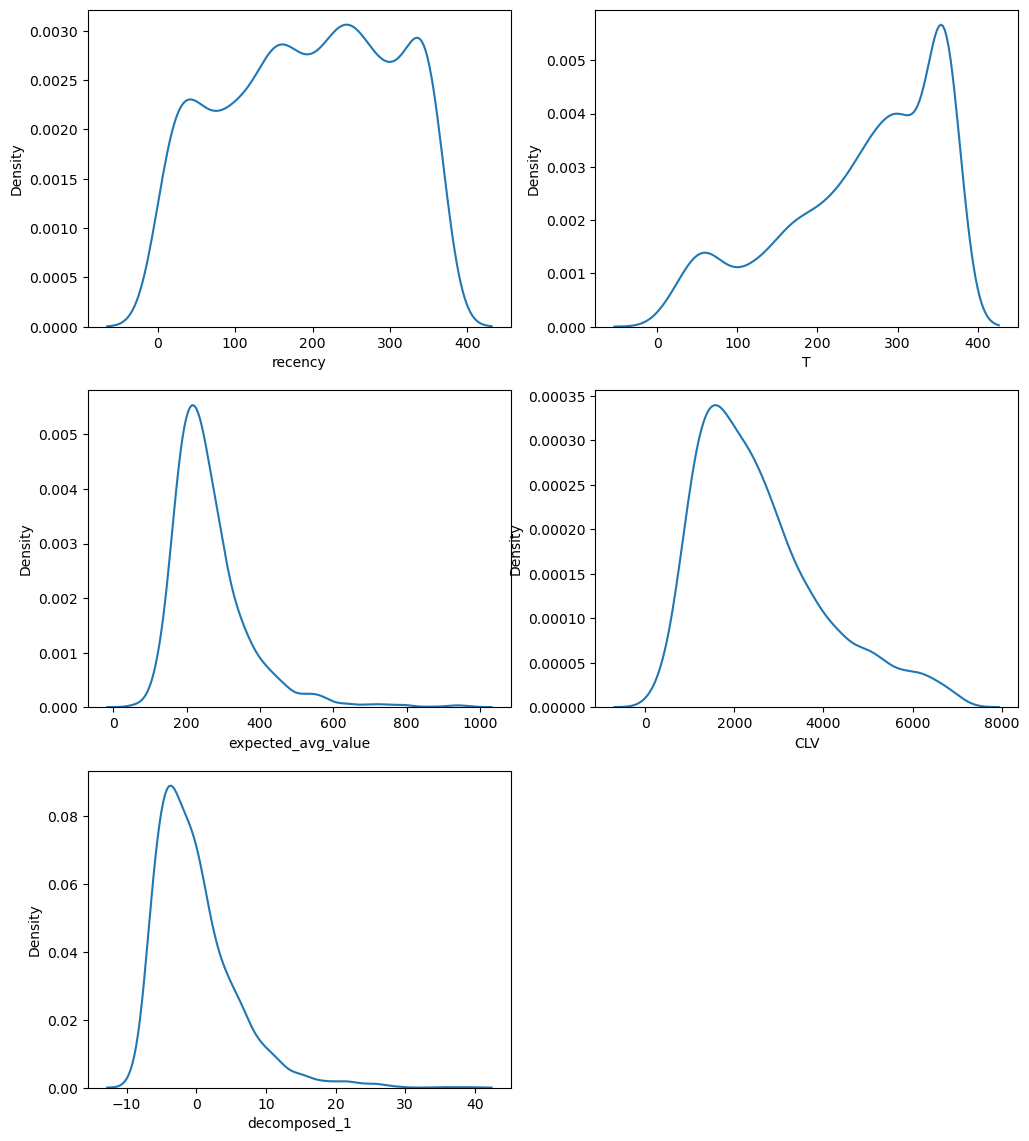

In [38]:
f,ax = plt.subplots(3,2,figsize=(12,14))
ax = ax.flatten()
for i,x in enumerate(df.columns):
    sns.kdeplot(df,x=x,ax=ax[i])
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel(x)
ax[5].axis('off')
plt.show()

In [39]:
data = data[(data["expected_avg_value"]<= 1000)]

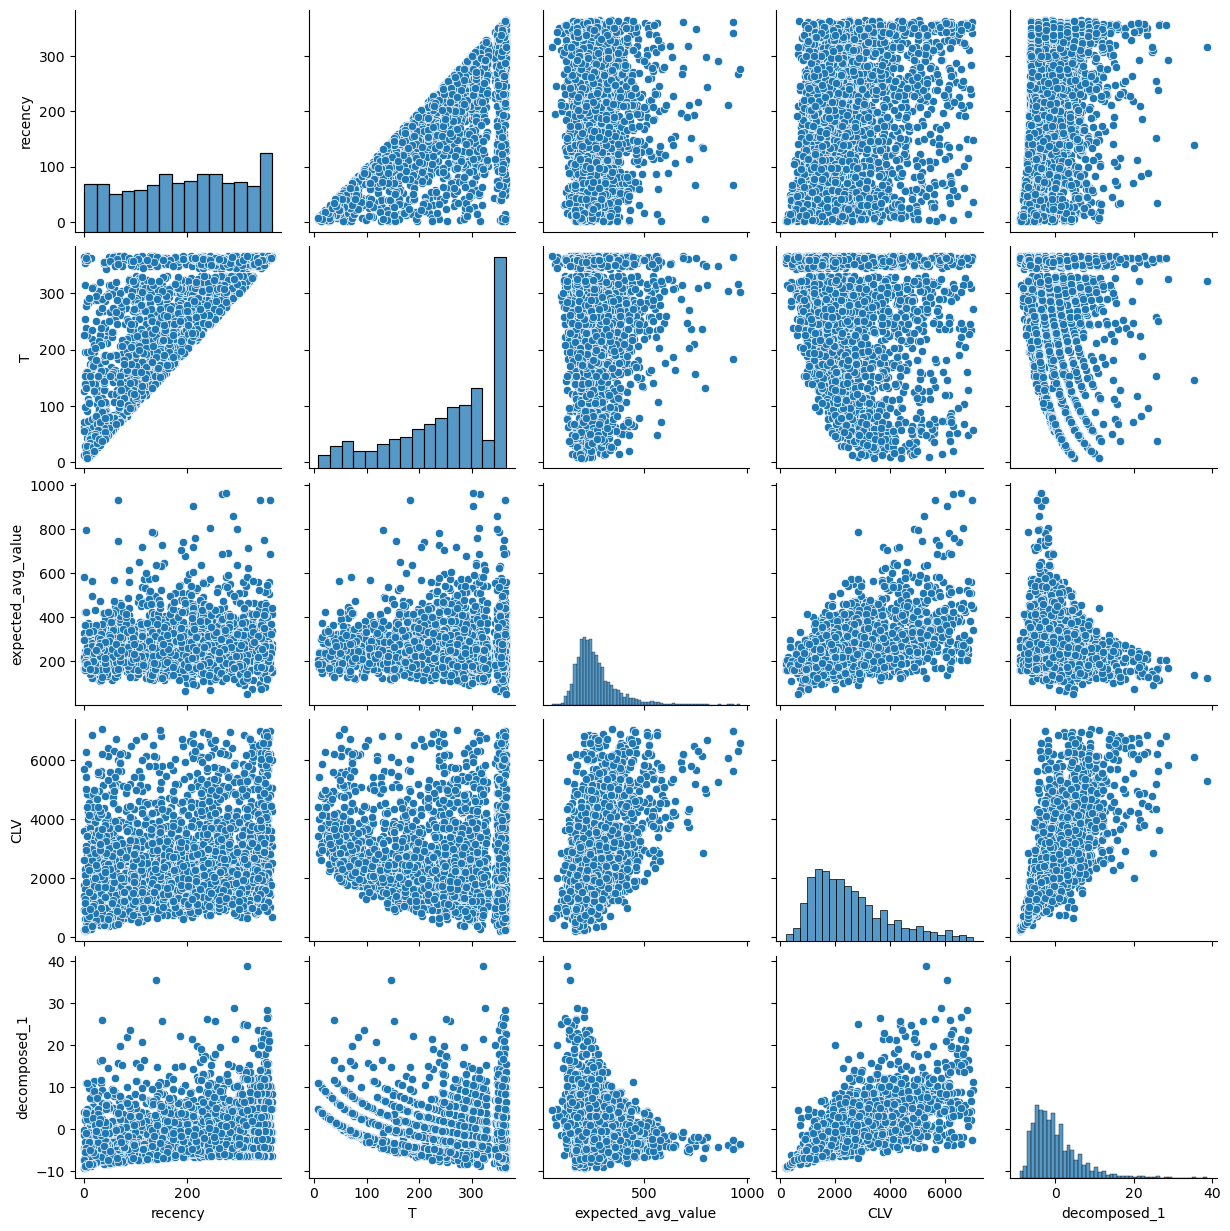

In [40]:
sns.pairplot(df)

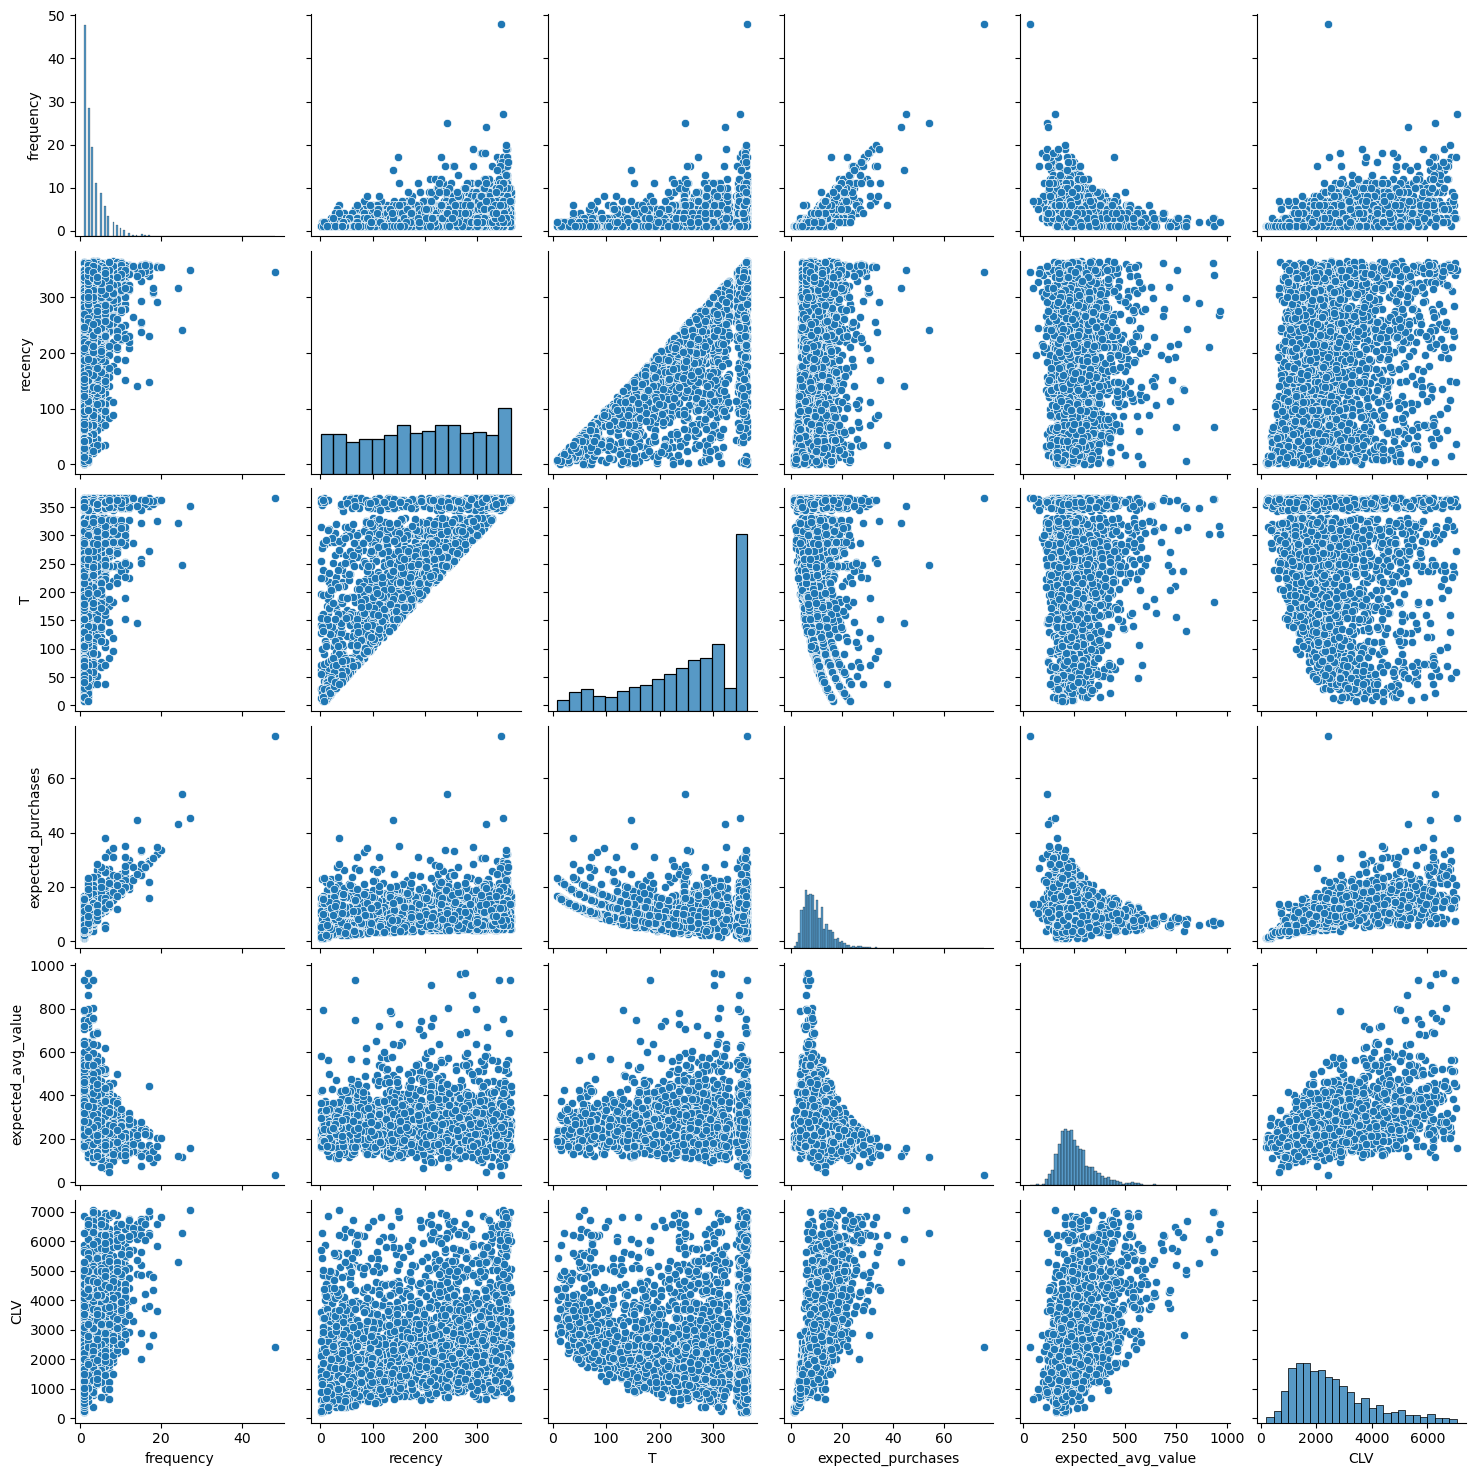

In [41]:
sns.pairplot(data)

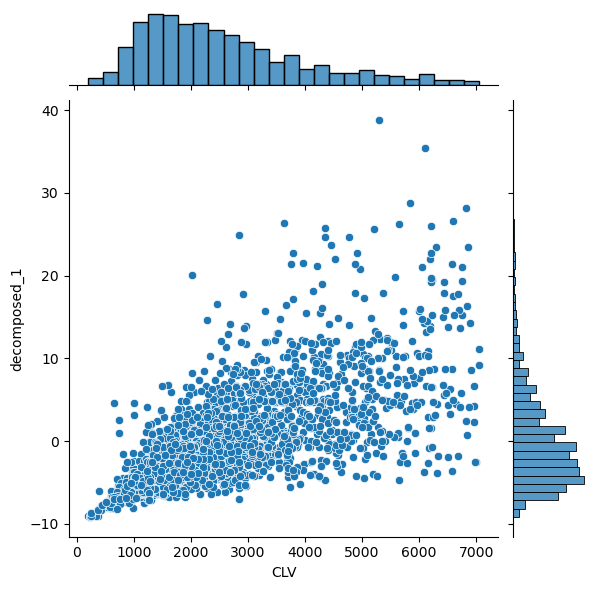

In [42]:
sns.jointplot(data=df,x='CLV',y='decomposed_1')

## Feature Engineering

## Test 1

**I didn't use Lasso because Lasso is good in feature selection here there is no features to ignore so ridge will be better**

In [43]:
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet

In [44]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split

In [45]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns="CLV"),df["CLV"],test_size=0.2)

In [46]:
lr = LinearRegression()
lr.fit(x_train,y_train)
print(lr.score(x_train,y_train))
y_pred = lr.predict(x_test)

0.9146760081463235


In [47]:
from sklearn.metrics import r2_score

In [48]:
print("Accuracy:",r2_score(y_test,y_pred))

Accuracy: 0.9147556055078117


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [50]:
rf = RandomForestRegressor(n_estimators=120,max_depth=5,min_samples_split=40)

In [51]:
rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_split=40, n_estimators=120)

In [52]:
ypred2 = rf.predict(x_test)

In [53]:
print("Accuracy:",r2_score(y_test,ypred2))

Accuracy: 0.9371531507595636


In [54]:
df.columns

Index(['recency', 'T', 'expected_avg_value', 'CLV', 'decomposed_1'], dtype='object')

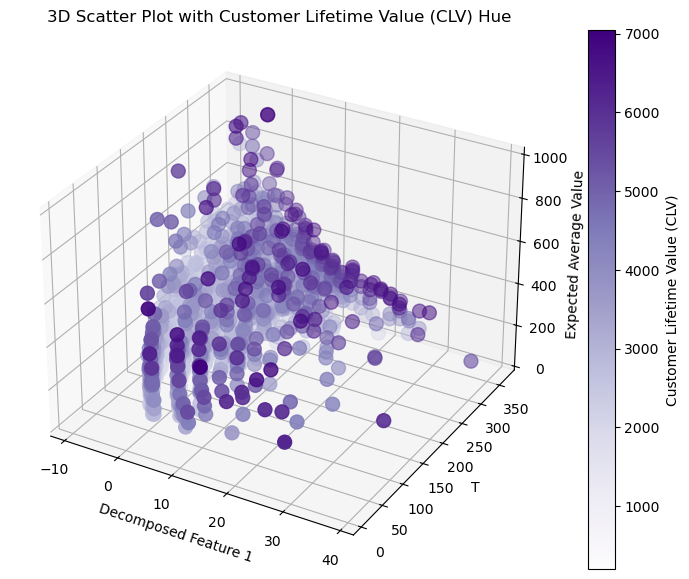

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplcursors
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['decomposed_1'], df['T'], df['expected_avg_value'], 
                 c=df['CLV'], cmap='Purples', s=100)
plt.colorbar(sc, label='Customer Lifetime Value (CLV)')
ax.set_xlabel('Decomposed Feature 1')
ax.set_ylabel('T')
ax.set_zlabel('Expected Average Value')
ax.set_title('3D Scatter Plot with Customer Lifetime Value (CLV) Hue')
plt.show()

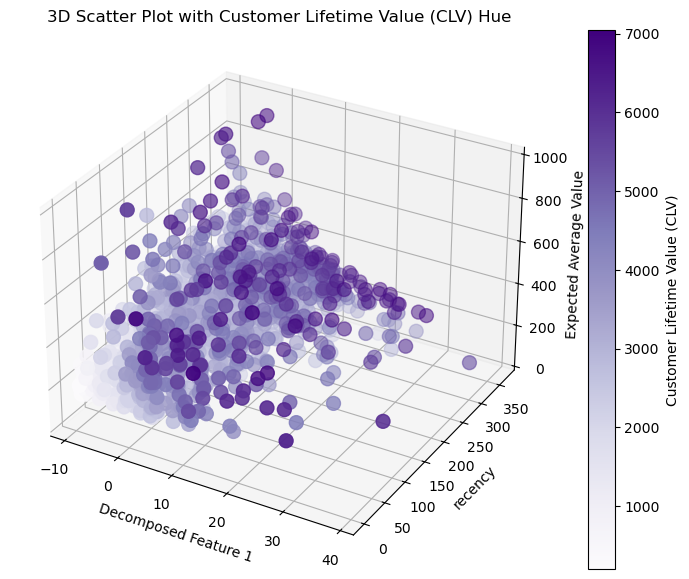

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplcursors
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['decomposed_1'], df['recency'], df['expected_avg_value'], 
                 c=df['CLV'], cmap='Purples', s=100)
plt.colorbar(sc, label='Customer Lifetime Value (CLV)')
ax.set_xlabel('Decomposed Feature 1')
ax.set_ylabel('recency')
ax.set_zlabel('Expected Average Value')
ax.set_title('3D Scatter Plot with Customer Lifetime Value (CLV) Hue')
plt.show()

In [57]:
import plotly.express as px

# Create the 3D scatter plot
fig = px.scatter_3d(df, x='decomposed_1', y='T', z='expected_avg_value',
                    color='CLV', title='3D Scatter Plot with CLV Hue',
                    labels={'decomposed_1': 'Decomposed Feature 1',
                            'T': 'Decomposed Feature 2',
                            'expected_avg_value': 'Expected Average Value'},width=1000,  # Width in pixels
                 height=800)

# Show the plot
fig.show()

In [58]:
svr = SVR(kernel='linear')
svr.fit(x_train,y_train)
ypred3 = svr.predict(x_test)
print("R2 Score:",r2_score(y_test,ypred3))

R2 Score: 0.907659764447104


### Test 2

In [59]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

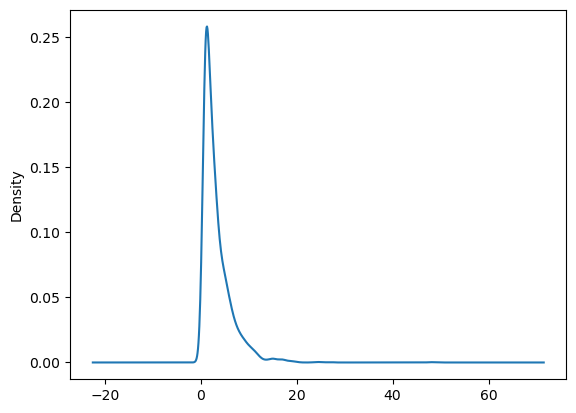

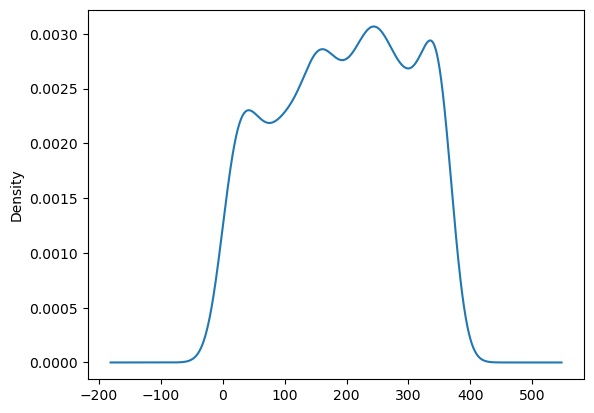

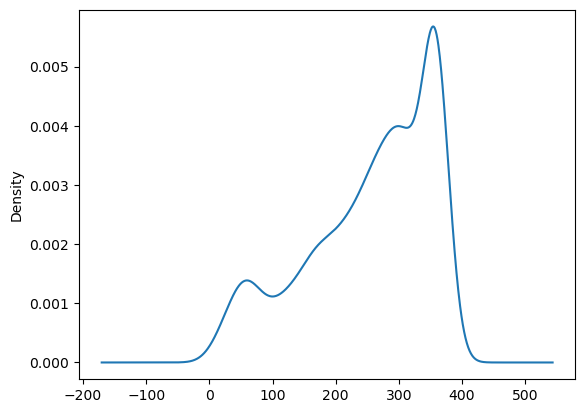

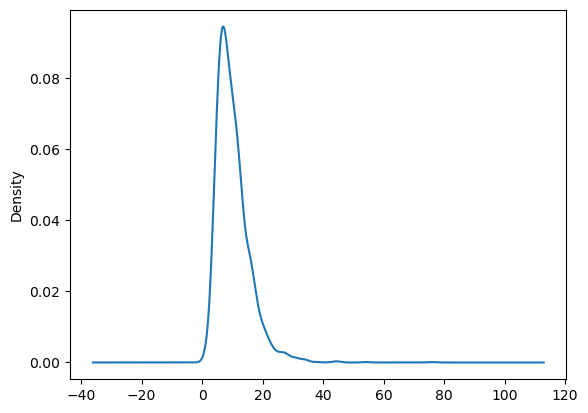

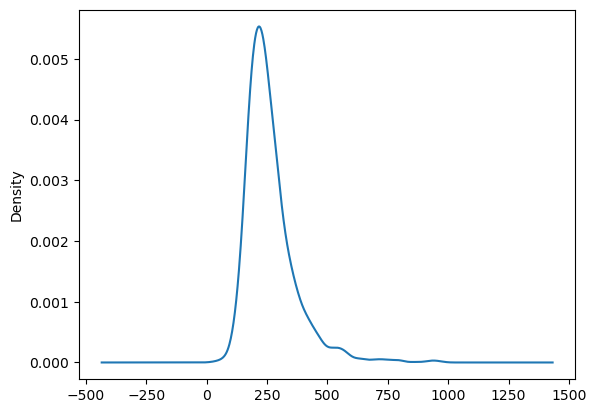

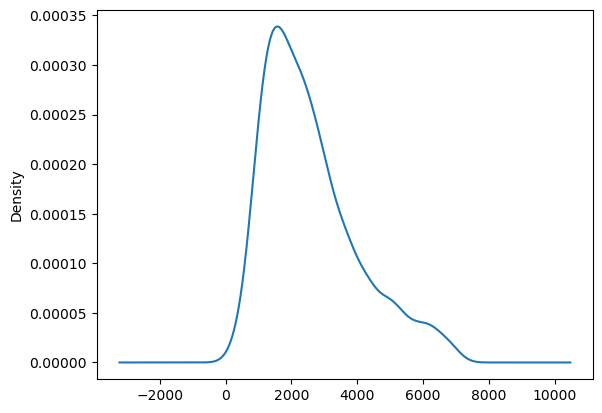

In [60]:
for x in data.columns:
    data[x].plot(kind='kde')
    plt.show()

In [61]:
list(data.columns[3:])

['expected_purchases', 'expected_avg_value', 'CLV']

In [62]:
l1 = list(data.columns[:1]) + list(data.columns[3:])
l2 = list(data.columns[1:3])

In [63]:
l1.remove("CLV")
print(l1)
print(l2)

['frequency', 'expected_purchases', 'expected_avg_value']
['recency', 'T']


In [64]:
X = data.drop(columns="CLV")
Y = data[["CLV"]]

In [65]:
sc = StandardScaler()
X[l1] = sc.fit_transform(X[l1])

In [66]:
from sklearn.preprocessing import QuantileTransformer 
quantile_transformer = QuantileTransformer(output_distribution='normal')
X[l2] = quantile_transformer.fit_transform(X[l2])

In [67]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(X,Y,test_size=0.2)

In [68]:
lr2 = LinearRegression()
lr2.fit(x_train2,y_train2)
y_lr2 = lr2.predict(x_test2)
print("Accuracy:",r2_score(y_test2,y_lr2))

Accuracy: 0.9025574447160132


In [69]:
params = {"n_estimators":[80,100,120,150],'max_depth':[4,6,8,10],'min_samples_leaf':[1,5,10]}

In [70]:
grf = GridSearchCV(RandomForestRegressor(),params,cv=5)

In [122]:
grf.fit(x_train2,y_train2.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [80, 100, 120, 150]})

In [123]:
grf.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=80)

In [124]:
grf.best_score_

0.9894405938986999

In [126]:
grf.best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 80}

In [71]:
rf2 = RandomForestRegressor(max_depth= 10, min_samples_leaf= 1, n_estimators= 80)
rf2.fit(x_train2,y_train2.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=80)

In [72]:
rf2.score(x_train2,y_train2.values.ravel())

0.9985450322706763

In [73]:
y_rf2 = rf2.predict(x_test2)
print("Accuracy:",r2_score(y_test2,y_rf2))

Accuracy: 0.9962276927500276


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense

In [75]:
from warnings import filterwarnings
filterwarnings("ignore")

In [76]:
x_train2.shape

(2039, 5)

In [77]:
ann = Sequential([Dense(units=100,activation='relu',input_shape=(5,)),
                 Dense(units=50,activation='relu'),
                 Dropout(0.3),
                 Dense(units=10,activation='relu'),
                 Dense(units=1)])

In [78]:
ann.compile(optimizer='adam',loss='mean_absolute_error')

In [79]:
ann.fit(x_train2,y_train2.values,batch_size=32,epochs=200)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2585.6086
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2560.4937
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2189.9944
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1272.7627
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 810.5652
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 644.7419
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 588.0048
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 481.6941
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 434.1052
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 394.2084
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 389.2176
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 382.9948
Epoch 13/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 402.5214
Epoch 14/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 364.1923
Epoch 15/200
64/64 ━━━━━━━━━━━━━━━━━━━━

In [81]:
anntr = ann.predict(x_train2,)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [82]:
annts = ann.predict(x_test2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [83]:
print("ANN Accuracy on Training set:", r2_score(y_train2,anntr))
print("ANN Accuracy on Testing set:", r2_score(y_test2,annts))

ANN Accuracy on Training set: 0.9816170591843194
ANN Accuracy on Testing set: 0.9927015001952078


- **Good There is no significant Variance and the bias is low that's means the data needed model to capture complex patterns in it**
- **Also by using Dropout our model is regularized**

## Saving Models

In [84]:
import pickle

In [85]:
pickle.dump(rf2,open('rf.pkl','wb'))

In [86]:
ann.save('ann.h5')
ann.save_weights('mymodel.weights.h5')

In [87]:
ann.save('kerasformatmodel.keras')

In [88]:
sc

StandardScaler()

In [89]:
pickle.dump(sc,open("scaler1.pkl",'wb'))
pickle.dump(quantile_transformer,open("scaler2.pkl",'wb'))

In [90]:
l1,l2

(['frequency', 'expected_purchases', 'expected_avg_value'], ['recency', 'T'])

**['frequency', 'expected_purchases', 'expected_avg_value']**  
**['recency', 'T']**